# CFMM liquidity on an orde book

- $f(x, y)$ - the CFMM's invariant function
- $A$ - current pool reserve of the base asset
- $B$ - current pool reserve of the quote asset
- $\Delta p$ - tick size
- $p_{\mathrm{m}}$ - marginal price (or, mid price)
- $p_n$ - the $n$-th tick below $p_{\mathrm{m}}$
- $a_n$ - the cumulative buy quantity from $p_{\mathrm{m}}$ to $p_n$
- $\Delta a_n$ - the size of the buy order at $p_n$

## The general case

$$
\begin{aligned}
p_{\mathrm{m}} &= \frac{\frac{\partial f}{\partial x}}{\frac{\partial f}{\partial y}} \\
p_0 &= p_{\mathrm{m}} \\
p_n &= p_{n-1} - \Delta p \\
a_0 &= 0 \\
a_n &= a: f(A, B) = f(A + a, B - p_n a) \\
\Delta a_0 &= 0 \\
\Delta a_n &= a_n - a_{n-1} \\
\end{aligned}
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def compute_bids(compute_p_m, compute_a, A, B, dp, half_spread, max_num_orders, **kwargs):
    # Compute the marginal price.
    p_m = compute_p_m(A, B, **kwargs)

    # Set the iterator's starting condition.
    p = p_m * (1 - half_spread)
    a = 0
    da = 0
    b = 0
    db = 0

    arr_p = [p_m]
    arr_a = [a]
    arr_da = [da]
    arr_b = [b]
    arr_db = [db]
    
    for n in range(1, max_num_orders + 1):
        # Terminate if price is less or equal to zero.
        if p <= 0:
            break

        # Compute the total order size (in base asset) at this price.
        a = compute_a(A, B, p, **kwargs)

        # Compute the order size (in base asset) at this price.
        da = a - arr_a[n - 1]

        # Compute the total order size (in quote asset) at this price.
        db = da * p
        b = arr_b[n - 1] + db

        # If total order size (in quote asset) is greater than the reserve, cap it to the reserve size.
        if b > B:
            b = B
            db = b - arr_b[n - 1]
            da = db * p
            a = arr_a[n - 1] + da

        # If order size rounds to zero, we have ran out of liquidity. Terminate the iterator.
        # Here we assume the base asset has 6 decimals, so < 1e-6 means rounding to zero.
        if da < 1e-6:
            break

        # Update the iterator state.
        arr_p.append(p)
        arr_a.append(a)
        arr_da.append(da)
        arr_b.append(b)
        arr_db.append(db)
        p -= dp

    return np.array(arr_p), np.array(arr_a), np.array(arr_da), np.array(arr_b), np.array(arr_db)


def compute_asks(compute_p_m, compute_a, A, B, dp, half_spread, max_num_orders, **kwargs):
    # Compute the marginal price.
    p_m = compute_p_m(A, B, **kwargs)

    # Set the iterator's starting condition.
    p = p_m * (1 + half_spread)
    a = 0
    da = 0
    b = 0
    db = 0

    arr_p = [p_m]
    arr_a = [a]
    arr_da = [da]
    arr_b = [b]
    arr_db = [db]

    for n in range(1, max_num_orders + 1):
        # Compute the total order size (in base asset) at this price.
        a = compute_a(A, B, p, **kwargs)

        # If total order size (in base asset) exceeds the base asset reserve, cap it to the reserve size.
        if a >= A:
            a = A

        # Compute the order size (in base asset) at this price.
        da = a - arr_a[n - 1]

        # If order size rounds to zero, we have ran out of liquidity. Terminate the iterator.
        # Here we assume the base asset has 6 decimals, so < 1e-6 means rounding to zero.
        if da < 1e-6:
            break
        
        # Compute the order size (in quote asset) at this price.
        # This isn't used in the smart contract logic. Just for plotting the graphs.
        db = da * p

        # Compute the total order size (in quote asset) at this price.
        b = arr_b[n - 1] + db

        # Update the iterator state.
        arr_p.append(p)
        arr_a.append(a)
        arr_da.append(da)
        arr_b.append(b)
        arr_db.append(db)
        p += dp

    return np.array(arr_p), np.array(arr_a), np.array(arr_da), np.array(arr_b), np.array(arr_db)


def plot(compute_p_m, compute_bid_a, compute_ask_a, A, B, dp, half_spread, max_num_orders=25, filename="", **kwargs):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

    # Compute and plot bids
    arr_p, arr_a, arr_da, arr_b, arr_db = compute_bids(compute_p_m, compute_bid_a, A, B, dp, half_spread, max_num_orders, **kwargs)
    ax1.bar(arr_p, arr_da, color="green", width=dp * 0.8)
    ax2.step(arr_p, arr_a, color="green", where="post")
    ax3.bar(arr_p, arr_db, color="green", width=dp * 0.8)
    ax4.step(arr_p, arr_b, color="green", where="post")

    print("---------------------- Bids -----------------------")
    print(pd.DataFrame(data={"p": arr_p, "a": arr_a, "da": arr_da, "b": arr_b, "db": arr_db}))

    # Compute and plot asks
    arr_p, arr_a, arr_da, arr_b, arr_db = compute_asks(compute_p_m, compute_ask_a, A, B, dp, half_spread, max_num_orders, **kwargs)
    ax1.bar(arr_p, arr_da, color="red", width=dp * 0.8)
    ax2.step(arr_p, arr_a, color="red", where="post")
    ax3.bar(arr_p, arr_db, color="red", width=dp * 0.8)
    ax4.step(arr_p, arr_b, color="red", where="post")

    print("---------------------- Asks -----------------------")
    print(pd.DataFrame(data={"p": arr_p, "a": arr_a, "da": arr_da, "b": arr_b, "db": arr_db}))

    ax4.set_xlabel("price (USD per SOL)")
    ax1.set_ylabel("order size (SOL)")
    ax2.set_ylabel("order depth (SOL)")
    ax3.set_ylabel("order size (USD)")
    ax4.set_ylabel("order depth (USD)")
    ax1.set_ylim(0)
    ax2.set_ylim(0)
    ax3.set_ylim(0)
    ax4.set_ylim(0)

    plt.tight_layout()
    if filename != "":
        plt.savefig(filename)
    plt.show()

## Xyk

$$
f(x, y) = xy
$$

$$
p_{\mathrm{m}} = \frac{B}{A}
$$

| BUY                        | SELL                      |
| -------------------------- | ------------------------- |
| $a_n = -A + \frac{B}{p_n}$ | $a_n = A - \frac{B}{p_n}$ |

---------------------- Bids -----------------------
        p         a        da         b        db
0   200.0  0.000000  0.000000  0.000000  0.000000
1   199.9  0.000500  0.000500  0.100000  0.100000
2   199.8  0.001001  0.000501  0.200050  0.100050
3   199.7  0.001502  0.000501  0.300150  0.100100
4   199.6  0.002004  0.000502  0.400300  0.100150
5   199.5  0.002506  0.000502  0.500501  0.100200
6   199.4  0.003009  0.000503  0.600751  0.100251
7   199.3  0.003512  0.000503  0.701052  0.100301
8   199.2  0.004016  0.000504  0.801404  0.100351
9   199.1  0.004520  0.000504  0.901805  0.100402
10  199.0  0.005025  0.000505  1.002257  0.100452
11  198.9  0.005530  0.000505  1.102760  0.100503
12  198.8  0.006036  0.000506  1.203313  0.100553
13  198.7  0.006543  0.000506  1.303916  0.100604
14  198.6  0.007049  0.000507  1.404571  0.100654
15  198.5  0.007557  0.000507  1.505276  0.100705
16  198.4  0.008065  0.000508  1.606031  0.100756
17  198.3  0.008573  0.000508  1.706838  0.10080

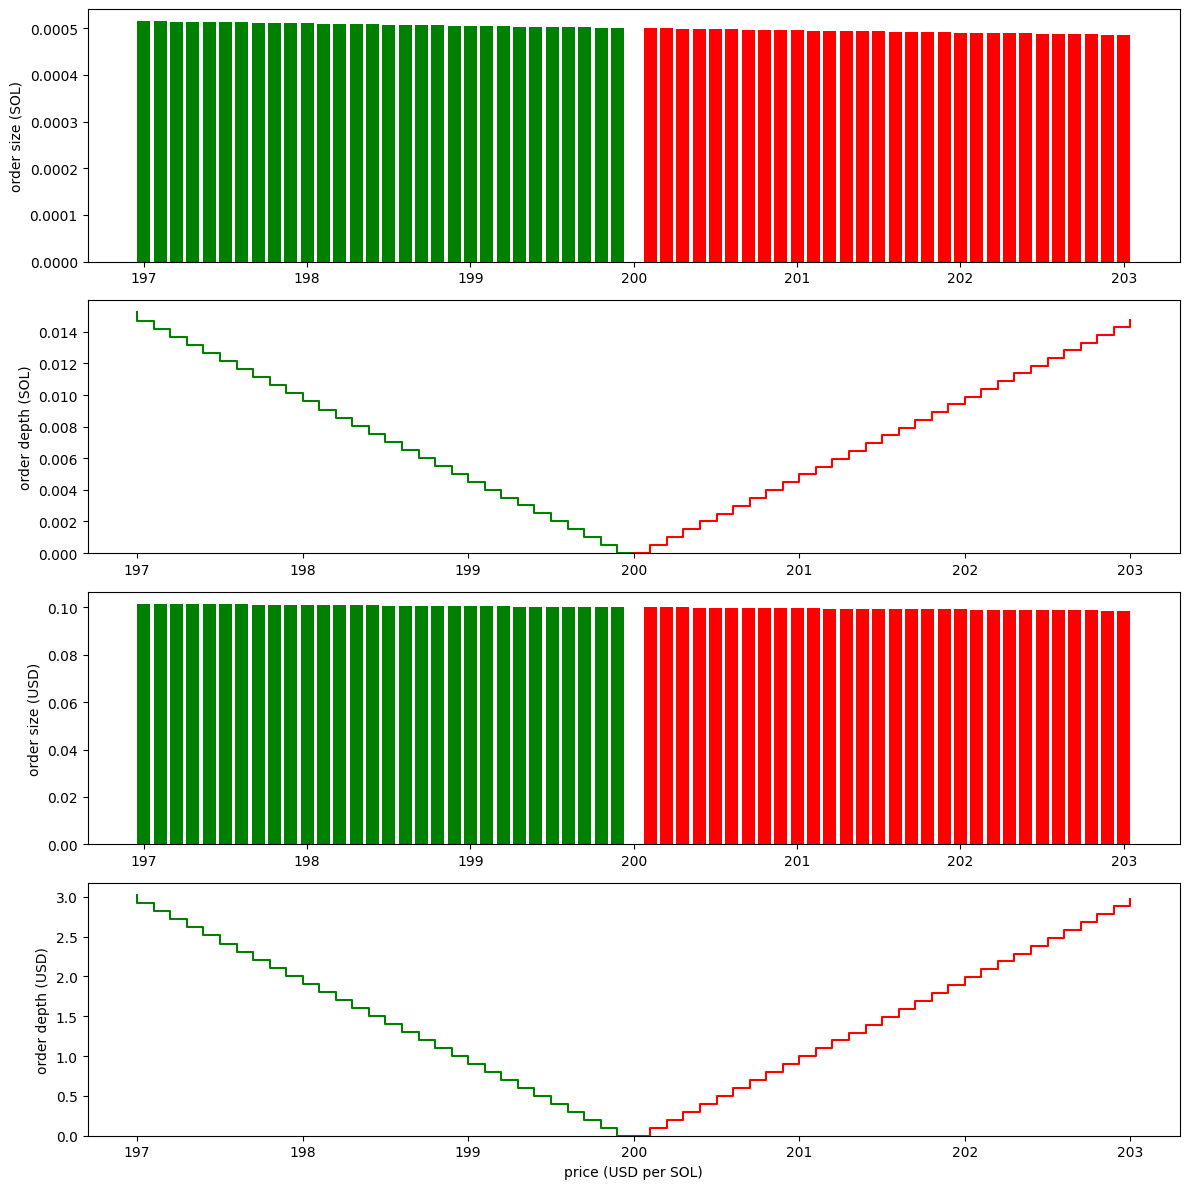

In [3]:
def compute_xyk_f(A, B):
    return A * B


def compute_xyk_p_m(A, B):
    return B / A


def compute_xyk_bid_a(A, B, p):
    return B / p - A


def compute_xyk_ask_a(A, B, p):
    return A - B / p

plot(compute_xyk_p_m,
     compute_xyk_bid_a,
     compute_xyk_ask_a,
     A=1,
     B=200,
     dp=0.1,
     half_spread=0.0005, # 0.05%
     max_num_orders=30,
     filename="")
     # filename="1-xyk.png")

## Solidly

$$
f(x, y) = x^3 \left(\frac{y}{R}\right) + x \left(\frac{y}{R}\right)^3
$$

$$
p_{\mathrm{m}} = \frac{3 R^2 A^2 B + B^3}{R^2 A^3 + 3 A B^2}
$$

| BUY                                                                                        | SELL                                                                                      |
| ------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------- |
| $\alpha = A + a$                                                                           | $\alpha = A - a$                                                                          |
| $\beta = \frac{B - p a}{R}$                                                                | $\beta = \frac{B + p a}{R}$                                                               |
| $g(a) = \alpha^3 \beta + \alpha \beta^3 - f(A, B)$                                         | $g(a) = \alpha^3 \beta + \alpha \beta^3 - f(A, B)$                                        |
| $g'(a) = -\frac{p}{R} \alpha^3 + a \alpha^2 \beta - \frac{3p}{R} \alpha \beta^2 + \beta^3$ | $g'(a) = \frac{p}{R} \alpha^3 - a \alpha^2 \beta + \frac{3p}{R} \alpha \beta^2 - \beta^3$ |

---------------------- Bids -----------------------
        p         a        da          b         db
0   200.0  0.000000  0.000000   0.000000   0.000000
1   199.9  0.100035  0.100035  19.996915  19.996915
2   199.8  0.126080  0.026046  25.200812   5.203897
3   199.7  0.144377  0.018297  28.854723   3.653911
4   199.6  0.158965  0.014588  31.766391   2.911668
5   199.5  0.171301  0.012337  34.227564   2.461173
6   199.4  0.182101  0.010800  36.381013   2.153449
7   199.3  0.191773  0.009672  38.308557   1.927544
8   199.2  0.200575  0.008802  40.061964   1.753408
9   199.1  0.208683  0.008108  41.676313   1.614348
10  199.0  0.216222  0.007539  43.176596   1.500283
11  198.9  0.223285  0.007062  44.581324   1.404729
12  198.8  0.229941  0.006656  45.904636   1.323311
13  198.7  0.236247  0.006306  47.157599   1.252963
14  198.6  0.242246  0.005999  48.349061   1.191462
15  198.5  0.247975  0.005729  49.486219   1.137158
16  198.4  0.253463  0.005488  50.575014   1.088795
17  198.3  0

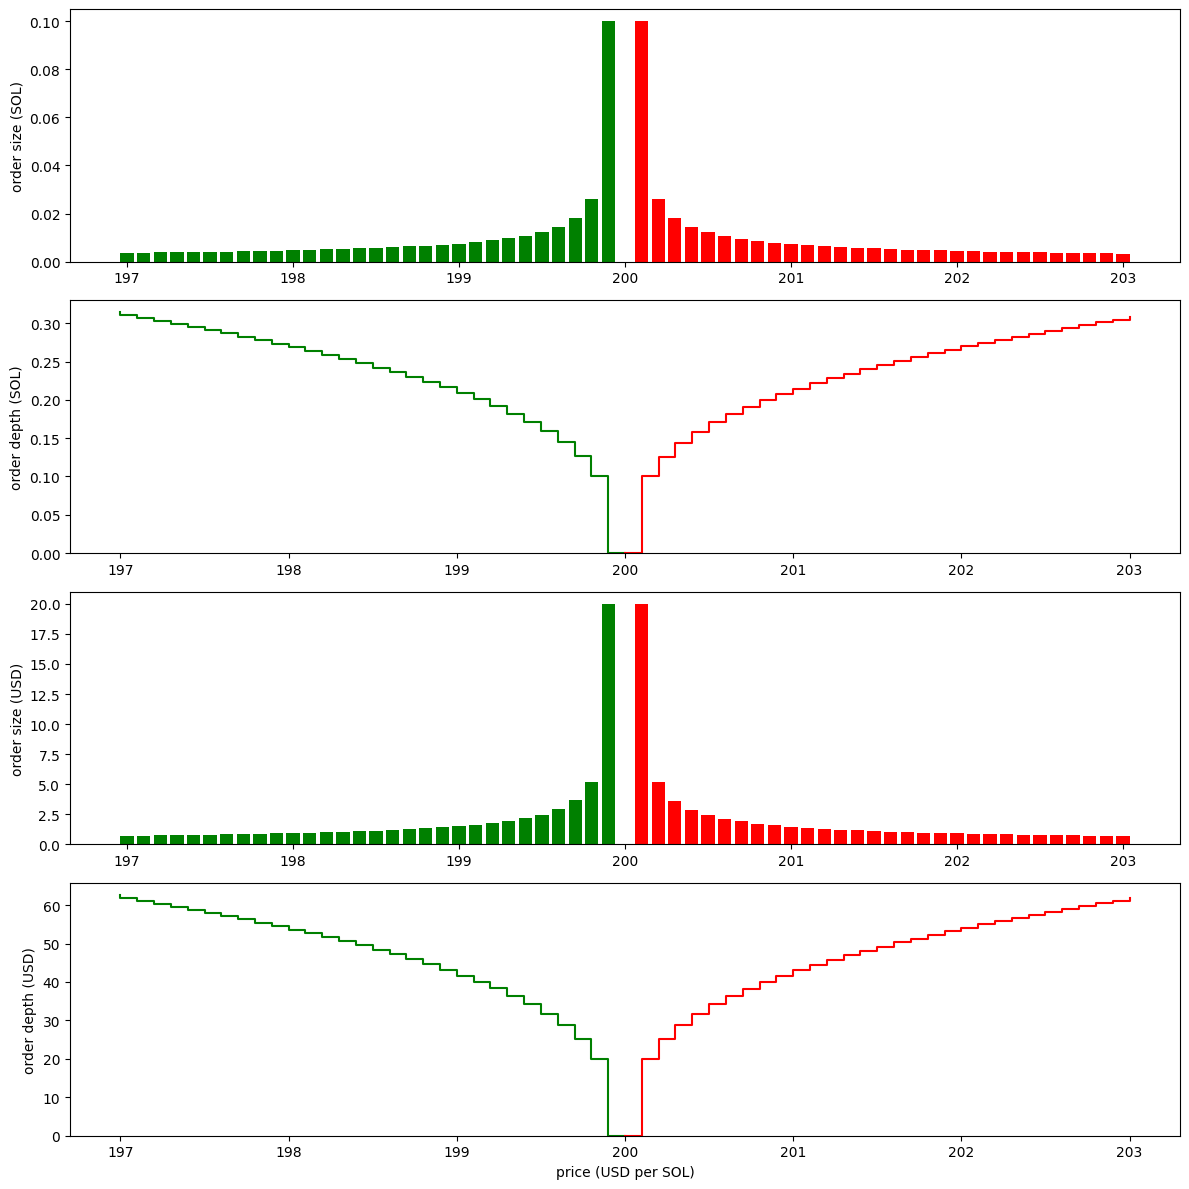

In [4]:
def compute_solidly_f(A, B, R):
    return A * A * A * B / R + A * B * B * B / R / R / R


def compute_solidly_p_m(A, B, R):
    return (3 * R * R * A * A * B + B * B * B) / (R * R * A * A * A + 3 * A * B * B)


def compute_solidly_bid_a(A, B, p, R, tolerance=1e-6, max_iterations=32):
    K = compute_solidly_f(A, B, R)
    a_prev = A
    for _ in range(max_iterations):
        alpha = A + a_prev
        beta = (B - p * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = - p * alpha * alpha * alpha / R + 3 * alpha * alpha * beta - 3 * p * alpha * beta * beta / R + beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")
    

def compute_solidly_ask_a(A, B, p, R, tolerance=1e-6, max_iterations=32):
    K = compute_solidly_f(A, B, R)
    a_prev = A
    for _ in range(max_iterations):
        alpha = A - a_prev
        beta = (B + p * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = p * alpha * alpha * alpha / R - 3 * alpha * alpha * beta + 3 * p * alpha * beta * beta / R - beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")


plot(compute_solidly_p_m,
     compute_solidly_bid_a,
     compute_solidly_ask_a,
     A=1,
     B=200,
     R=200,
     dp=0.1,
     half_spread=0.0005, # 0.05%
     max_num_orders=30,
     filename="")
     # filename="2-solidly.png")

---------------------- Bids -----------------------
             p         a        da          b         db
0   209.993906  0.000000  0.000000   0.000000   0.000000
1   209.888909  0.066144  0.066144  13.882865  13.882865
2   209.788909  0.090284  0.024140  18.947148   5.064283
3   209.688909  0.107511  0.017227  22.559544   3.612396
4   209.588909  0.121329  0.013818  25.455678   2.896134
5   209.488909  0.133052  0.011723  27.911492   2.455814
6   209.388909  0.143334  0.010282  30.064352   2.152860
7   209.288909  0.152553  0.009219  31.993770   1.929418
8   209.188909  0.160950  0.008397  33.750390   1.756620
9   209.088909  0.168690  0.007740  35.368686   1.618296
10  208.988909  0.175889  0.007200  36.873309   1.504623
11  208.888909  0.182636  0.006746  38.282567   1.409258
12  208.788909  0.188996  0.006360  39.610472   1.327905
13  208.688909  0.195022  0.006026  40.868014   1.257542
14  208.588909  0.200755  0.005734  42.063990   1.195977
15  208.488909  0.206231  0.005475  

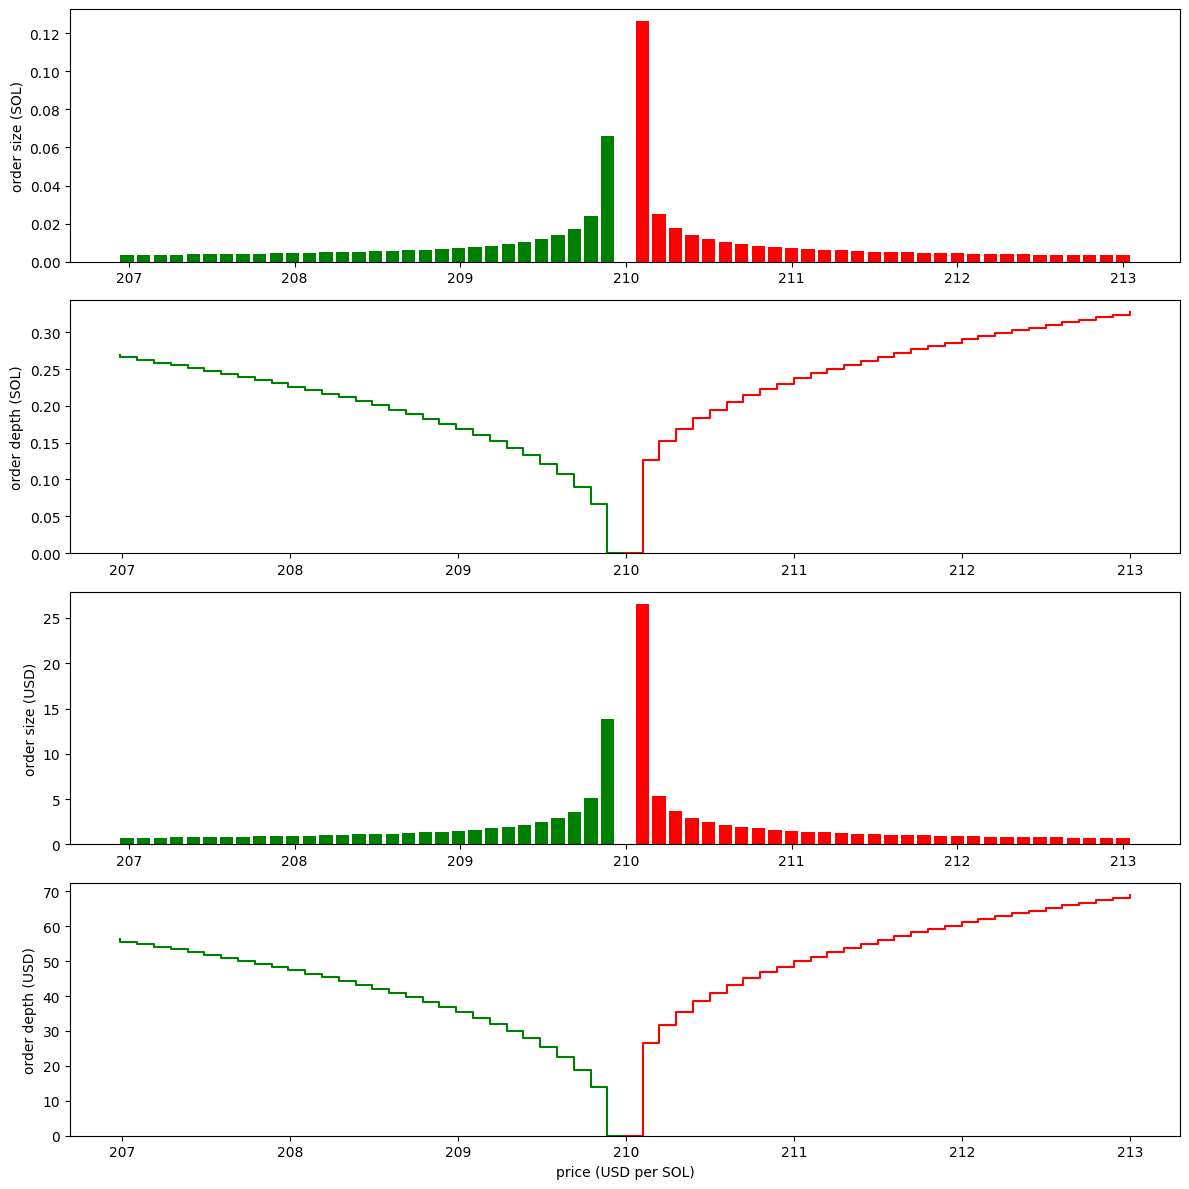

In [5]:
plot(compute_solidly_p_m,
     compute_solidly_bid_a,
     compute_solidly_ask_a,
     A=1,
     B=200,
     R=210,
     dp=0.1,
     half_spread=0.0005, # 0.05%
     max_num_orders=30,
     filename="")
     # filename="3-solidly-price-jump.png")